Deep Learning Lab 02 - Neural Network Basics
# Implementing a Multi-layer Perceptron in NumPy

## 0 - Packages
At first, let's import all packages we will need today:

- [numpy](www.numpy.org) remember our first lab: NumPy is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42) # set a seed so that the results are consistent

## 1 - Obtaining the Image Dataset

Execute the code below for downloading the dataset to `/tmp/binary_flowers.npz`:

In [ ]:
#@title Download Dataset
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_file_from_google_drive('1BoDcLIEqfb9qD5VJBKr4BhArluPyOBrh', '/tmp/binary_flowers.npz')

The dataset is provided as archive of numpy arrays, each stored as binary file. We'll unpack them to `X_train, y_train, X_test, y_test`:

In [ ]:
with np.load('/tmp/binary_flowers.npz') as data:
    X_train, y_train, X_test, y_test = [ data[key] for key in ['X_train', 'y_train', 'X_test', 'y_test'] ]

#print(' {} training and {} test samples loaded.'.format(y_train.size, y_test.size))

# reshaping
X_train.shape = (X_train.shape[0], np.product( X_train.shape[1:]))
X_train = X_train.T
X_test.shape = (X_test.shape[0], np.product( X_test.shape[1:]))
X_test = X_test.T

## 2 - Implementing a 2 Layer Neural Network

Let's get started implementing our neural network.

**Exercise**: The code below contains several `# TODO`s. Fix them based on our discussion.


In [ ]:
import sys

class NeuralNet():
  '''Feed-forward neural network with 1 hidden layer

  Parameters
  ------------
  n_hidden : int (default:10)
  l2_lambda : float (default: .01)
        Lambda value for L2-regularization.
  epochs : int (default: 20)
        Number of runs over the complete training set.
  alpha : float (default: .001)
        Learning rate
  shuffle : bool (default: True)
        If true, training data is shuffled every epoch.
  minibatch_size : int (default: 1)
      Number of training samples per minibatch.
  seed : int (default: None)
      Random seed for initializing weights and shuffling.

  Attributes
  ------------
  eval_ : dict
    Dictionary collecting the cost, training accuracy,
    and validation accuracy for every training epoch.
  '''

  def __init__(self, n_hidden=10,
               l2_lambda=.01, epochs=20, 
               alpha=.001, shuffle=True,
               minibatch_size=1, seed=None):
    
    self.random = np.random.RandomState(seed)
    self.n_hidden = n_hidden
    self.l2_lambda = l2_lambda
    self.epochs = epochs
    self.alpha = alpha
    self.shuffle = shuffle
    self.minibatch_size = minibatch_size
    self._number_of_parameters = None

  def _sigmoid(self, z):
    '''Compute sigmoid (logistic) function'''
    return 1./(1 + np.exp(-z)) # TODO

  def initialize_weights(self, n_features):
    '''Initialize weights of the hidden and output layer

    Parameters
    ------------
    n_features : int
        Number of input features.
    '''
    # Weights of the hidden layer
    self.b1 = np.zeros( (self.n_hidden, 1) )
    self.W1 = np.random.normal( scale=.1,
                               size=(self.n_hidden, n_features))
    
    # Weights of the output layer
    self.b2 = np.zeros( (1, 1) )
    self.W2 = np.random.normal( scale=.1,
                               size=(1, self.n_hidden))
    
    print('Network initialized. Total number of parameters: {}'.format(self.number_of_parameters))

  def _forward(self, X):
    '''Compute forward propagation step'''

    # step 1: net input of hidden layer
    # (n_hidden, n_features) dot (n_features, n_samples) => (n_hidden, n_samples)
    Z1 = np.dot( self.W1, X ) + self.b1

    # step 2: activation of hidden layer
    A1 = self._sigmoid( Z1 )

    # step 3: net input of output layer
    # (n_output, n_hidden) dot (n_hidden, n_samples) => (n_output, n_samples)
    Z2 = np.dot( self.W2, A1 ) + self.b2

    # step 4: activation of output layer
    A2 = self._sigmoid( Z2 )

    # compare output shape
    assert( A2.shape == (1, X.shape[1]) ), 'Incompatible output shape: {}'.format(A2.shape)

    return Z1, A1, Z2, A2

  def predict(self, X):
    '''Predict class labels
    
    Parameters
    ------------
    X : array, shape = (n_features, n_samples)
        Original input features.
        
    Returns
    ---------
    y_prediction : array, shape = (n_samples)
        Predicted boolean label.
    '''
    _, _, _, A2 = self._forward(X)
    y_prediction = np.round( A2 )

    return y_prediction

  def _compute_cost(self, y, output):
    '''Compute the cost function.

    Parameters
    ------------
    y : array, shape = (n_samples,)
        Array of binary labels.
    output : array, shape = (n_samples,)
        Activation of the output layer.

    Returns
    ---------
    cost : float
        (Regularized) cost of the output.
    '''

    L2_term = ( self.l2_lambda * 
               (np.sum(self.W1 ** 2.) + 
                np.sum(self.W2 ** 2.)) )
    
    cost = - np.mean( y * np.log(output) + (1 - y) * np.log(1 - output) ) + L2_term

    return cost
    
  def plot_loss(self):
    if not hasattr(self, 'eval_'):
      print('No evaluation history found. Run `.fit` to train your model.')
      return
    plt.plot(range(self.epochs), self.eval_['cost'])
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.show()

  def plot_accuracy(self):
    if not hasattr(self, 'eval_'):
      print('No evaluation history found. Run `.fit` to train your model.')
      return
    plt.plot(range(self.epochs), self.eval_['train_acc'], 
         label='training')
    plt.plot(range(self.epochs), self.eval_['valid_acc'], 
            label='validation', linestyle='--')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

  @property
  def number_of_parameters(self):
    if hasattr(self, 'w_hidden'):
      self._number_of_parameters = np.sum([layer.size for layer in (
          self.W1, self.b1, self.W2, self.b2)])
    else:
      print('No network parameters found.')
    return self._number_of_parameters

  def fit(self, X_train, y_train, X_valid, y_valid):
    '''Learn weights from training data.

    Parameters
    ------------
    X_train : array, shape = (n_features, n_samples)
        Original input features for training.
    y_train : array, shape = (n_samples,)
        Array of binary labels for training.
    X_valid : array, shape = (n_features, n_samples)
        Original input features for validation.
    y_valid : array, shape = (n_samples,)
        Array of binary labels for validation.

    Returns
    ---------
    self
    '''

    print()
    
    n_output = 1
    n_features = X_train.shape[0]

    self.initialize_weights(n_features)

    epoch_strlen = len(str(self.epochs))  # for progress formatting
    self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

    # iterate over training epochs
    for i in range(self.epochs): # TODO 1

      # iterate over minibatches
      indices = np.arange(X_train.shape[1])

      if self.shuffle:
        self.random.shuffle(indices) # TODO 2

      for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
        batch_idx = indices[start_idx:start_idx + self.minibatch_size]

        # forward propagation
        # TODO 3
        Z1, A1, Z2, A2 = self._forward(X_train[:, batch_idx])

        ### backpropagation ###

        # (n_output, n_samples)
        # TODO 4
        dZ2 = A2 - y_train[batch_idx]

        # (n_output, n_samples) dot (n_samples, n_hidden) => (n_output, n_hidden)
        # TODO 5
        dW2 = np.dot( dZ2, A1.T )

        # sum(sigma_output) => (n_output,)
        # TODO 6
        db2 = np.sum( dZ2, axis=1 )

        # (n_hidden, n_samples)
        # TODO 7
        dA1dZ1 = A1 * (1. - A1)

        # (n_hidden, n_output) dot (n_output, n_samples) => (n_hidden, n_samples)
        # TODO 8
        dZ1 = np.dot( self.W2.T, dZ2 ) * dA1dZ1

        # (n_hidden, n_samples) dot (n_samples, n_features) => (n_hidden, n_features)
        # TODO 9
        dW1 = np.dot( dZ1, X_train[:, batch_idx].T )

        # sum(sigma_hidden) => (n_hidden,)
        # TODO 10
        db1 = np.sum( dZ1, axis=1, keepdims=True )

        # regularization
        dW2 += self.l2_lambda * self.W2
        dW1 += self.l2_lambda * self.W1

        ### weight updates ###
        # TODO 11
        self.W2 -= self.alpha * dW2
        self.b2 -= self.alpha * db2

        self.W1 -= self.alpha * dW1
        self.b1 -= self.alpha * db1

      ### evaluation ###

      # eval after each epoch during training
      Z1, A1, Z2, A2 = self._forward(X_train)
      cost = self._compute_cost( y=y_train, output=A2 )

      y_train_pred = self.predict(X_train)
      y_valid_pred = self.predict(X_valid)

      train_acc = np.mean( y_train == y_train_pred )
      valid_acc = np.mean( y_valid == y_valid_pred )

      sys.stderr.write('\rProgress: {}/{} | '.format(i+1, self.epochs) + \
                             'Cost: {:.2f} | '.format(cost) + \
                             'Train/Valid Acc.: {:.2f}%/{:.2f}% '.format(train_acc*100, valid_acc*100))
      
      sys.stderr.flush()

      self.eval_['cost'].append(cost)
      self.eval_['train_acc'].append(train_acc)
      self.eval_['valid_acc'].append(valid_acc)
  
    return self


## 3 - Training and Evaluation
Now it's time to finally train your network. Create a network with 10 neurons in the hidden layer. Then train it for 100 epochs with a minibatch size of 100 using the `.fit()` method:

In [51]:
# TODO 12
my_NN = NeuralNet(n_hidden=10, minibatch_size=100, epochs=10, shuffle=True)
my_NN.fit(X_train=X_train, X_valid=X_test, y_train=y_train, y_valid=y_test)


No network parameters found.
Network initialized. Total number of parameters: None


Progress: 10/10 | Cost: 12.86 | Train/Valid Acc.: 75.72%/84.00% 

We can use `.predict()` method on the test data in order to finally evaluate the performance of our network:

In [52]:
predictions = my_NN.predict(X_test)
print('Accuracy: {:.1f}%'.format( np.mean(y_test == predictions)*100 ))

Accuracy: 84.0%


During training, we stored the loss and the training and validation accuracy of the network after each epoch. Our `.plot_loss()` method uses this data for plotting the learning curve:

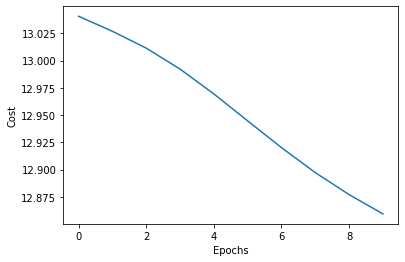

In [53]:
my_NN.plot_loss()

With `.plot_accuracy()` we can plot the accuracy achieved on both training and validation set after each epoch:

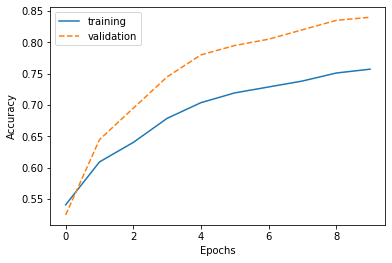

In [54]:
my_NN.plot_accuracy()

## Congratulations!
You've just coded your own neural network in NumPy and trained it to recognize flowers in images! You may play a litte with the hyperparameters, e.g., set the learning rate `alpha` to `0.0003` and increase the hidden layer size `n_hidden`.
To also classify the type of flower from an image, you may continue with the next assignment. Have fun and much success!